In [8]:
import torch
torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [16]:
# set up param

SEED = 309

IMG_SIZE = 360
ROT_SIZE = 90
TRAIN_PATH = './data/test'
TEST_PATH = './data/train'
BATCH = 4


In [17]:
# IMPORTS

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms

In [4]:
# split data :)

#%pip install split-folders
import splitfolders
splitfolders.ratio('./origData', output="./data", seed=SEED, ratio=(.7, 0,0.3)) 

Copying files: 4418 files [00:01, 2814.91 files/s]


In [18]:
# from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


In [19]:
# import data & stuff
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.io import read_image


trainDataTransform = transforms.Compose( [
                         transforms.Resize((IMG_SIZE,IMG_SIZE)),
                         transforms.RandomRotation(ROT_SIZE),
                         transforms.RandomHorizontalFlip(),
                         transforms.ToTensor() ])
    
testDataTransform  = transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                         transforms.ToTensor()])


train_folder = torchvision.datasets.ImageFolder(TRAIN_PATH, transform=trainDataTransform)
test_folder  = torchvision.datasets.ImageFolder(TEST_PATH,  transform=testDataTransform)  

trainLoader = torch.utils.data.DataLoader(train_folder, shuffle=True, batch_size = BATCH)
testLoader  = torch.utils.data.DataLoader(test_folder,  shuffle=True, batch_size = BATCH)

classes = ('cherry', 'strawberry', 'tomato')

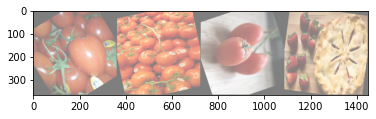

tomato tomato tomato strawberry


In [20]:
train_iter = iter(trainLoader)
images, labels = next(train_iter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [ ]:
# from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# from  https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

n = 2

for epoch in range(n):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

In [ ]:
# SAVE MODEL

PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)